In [1]:
import sys
from pathlib import Path
import logging
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# --- Setup Logging and Paths ---
logging.basicConfig(level=logging.INFO, filename='notebook.log', filemode='w')
logger = logging.getLogger(__name__)

project_root = Path('.').resolve()
src_path = project_root / 'layered-context-graph' / 'src'
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))
logger.info(f"Project root set to: {project_root}")

from models.baai_model import BAAIModel
from partitioning.partition_manager import PartitionManager

In [2]:
# --- Cell 2: Model Initialization ---
BAAI_MODEL_PATH = './bge-en-icl'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Initializing BAAIModel (lazy)...")
baai_model = BAAIModel(BAAI_MODEL_PATH, device)
print("BAAIModel initialized.")

Initializing BAAIModel (lazy)...
BAAIModel initialized.


In [ ]:
# --- Cell 3: End-to-End Partition and Graph Test ---
    line_text = """The sun rises in the east. Birds sing. Later, the topic shifts to astrophysics. The lifecycle of a star is complex. Returning to our original theme, the weather is warm."""
pipeline_text = open('Layer_Context_Window_Graphs', 'r').read() if Path('Layer_Context_Window_Graphs').exists() else pipeline_text
# 1. Partitioning and Graph Creation
partition_manager = PartitionManager(embedding_model=baai_model, similarity_threshold=0.7, cohesion_threshold=0.5)
graph_data = partition_manager.create_partition_graph(pipeline_text)
print(f"Graph construction complete. Found {len(graph_data['nodes'])} nodes and {len(graph_data['edges'])} edges.")

Model device: meta
Model device after loading: cuda:0
Graph construction complete. Found 404 nodes and 324 edges.


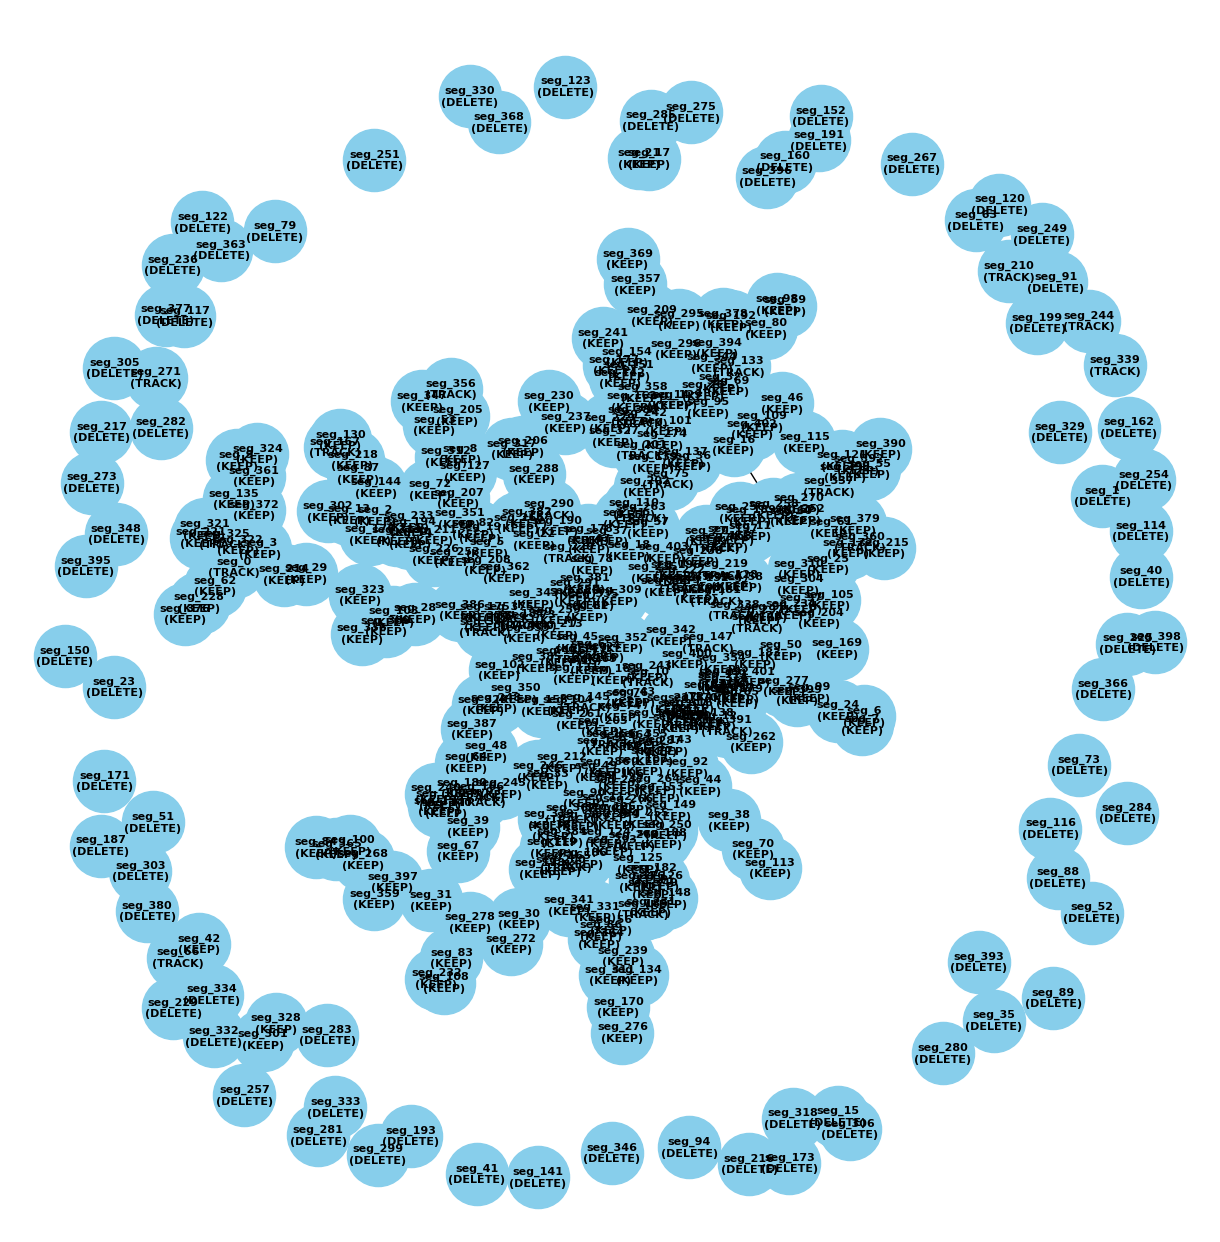

In [7]:
# --- Cell 4: Visualize the Graph ---
if graph_data and graph_data['nodes']:
    G = nx.Graph()
    for node in graph_data['nodes']:
        G.add_node(node['id'], label=f"{node['id']}\n({node.get('tag', 'N/A')})", content=node['content'])
    
    # Correctly handle the edge data format
    for edge_tuple in graph_data['edges']:
        if len(edge_tuple) == 3:
            u, v, data = edge_tuple
            G.add_edge(u, v, **data)
        elif len(edge_tuple) == 2:
            u, v = edge_tuple
            G.add_edge(u, v)

    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G, seed=42)
    labels = nx.get_node_attributes(G, 'label')
    nx.draw(G, pos, labels=labels, with_labels=True, node_size=2000, node_color='skyblue', font_size=8, font_weight='bold')
    plt.title('Knowledge Graph from PartitionManager')
    plt.show()
else:
    print("No graph data to visualize.")


In [ ]:
# --- Cell 5: Print Deleted Segments ---
print("--- Segments Marked for Deletion ---")
deleted_segments = [node for node in graph_data['nodes'] if node.get('tag') == 'DELETE']

if deleted_segments:
    for i, node in enumerate(deleted_segments):
        print(f"--- Deleted Segment {i+1} (ID: {node['id']}) ---")
        print(node['content'])
        print(node['code'])
        print("-" * 40)
else:
    print("No segments were marked for deletion.")



--- Segments Marked for Deletion ---
--- Deleted Segment 1 (ID: seg_1) ---
## Technical Core ### Technical Core - Section 1 *Type: Technical Core | Importance: 12.0* ### 1. **Head Specialization Discovery**
```python
def discover_head_specializations(self, model, test_corpus):
    """Automatically find what each head is good at"""
    
    head_skills = {}
    
    for layer in range(model.config.num_hidden_layers):
        for head in range(model.config.num_attention_heads):
            # Test each head on different tasks
            boundary_score = test_boundary_detection(layer, head, test_corpus)
            relation_score = test_relation_detection(layer, head, test_corpus)
            cluster_score = test_clustering_ability(layer, head, test_corpus)
            
            head_skills[(layer, head)] = {
                'boundary': boundary_score,
                'relation': relation_score,
                'cluster': cluster_score
            }
    
    # Assign heads to rules bas